In [1]:
import boto3
import cv2
import io
import os
import s3fs
import torch

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import torch.nn as nn

from collections import OrderedDict
from PIL import Image
from torch import optim
from torch.utils.data import Dataset, DataLoader 
from torchvision import datasets, models, transforms

#### s3 configuration

In [2]:

s3 = boto3.resource("s3",
                    endpoint_url = "http://192.168.0.29",
                    aws_access_key_id="AKIAPo19vPR_TJaeVgleCiOSUw",
                    aws_secret_access_key="7cSWM1KCXvRpK4ICeDEAfuicEm+QQeuhqOi7cejZ",
                    region_name = 'eu-central-1',
               )

kwargs = {'endpoint_url':"http://192.168.0.29",
          }
client = s3fs.S3FileSystem(key="AKIAPo19vPR_TJaeVgleCiOSUw", 
                                secret="7cSWM1KCXvRpK4ICeDEAfuicEm+QQeuhqOi7cejZ",
                                use_ssl=False,
                            
                                client_kwargs=kwargs)


In [3]:
my_bucket = s3.Bucket("sample-dataset")

In [4]:
map_labels = {"Apple___Apple_scab":0, "Apple___Black_rot":1, 
          "Apple___Cedar_apple_rust":2, "Apple___healthy":3, "Background_without_leaves":4}

#### Create Custom Dataset to Load data
- Pytorch do not have any existing Dataset Loader classes that fetch data from s3. Therefore we need to create a custom Dataset Loader that will fetch the data from Cortx-s3.

In [5]:

class ImageDataset(Dataset):
   
    def __init__(self, path="s3://sample-dataset/sample_data/", transform=None):
        self.path = path
        self.classes = [folder["name"] for folder in client.listdir(path)][2:]
        self.files = []
        for directory in self.classes:
            self.files += [file for file in client.ls(directory)][1:]

        self.transform = transform

    def __len__(self):
        return len(self.files)
 

    def __getitem__(self, idx):
        img_name = self.files[idx]
        label = img_name.split("/")[-2]
        label = map_labels[label]
        
        key = img_name.split("/")
        key = "/".join(key[1:])
      
        img_name = my_bucket.Object(key).get().get('Body').read()
       
        image = cv2.imdecode(np.asarray(bytearray(img_name)), cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label).long()
        return image, label

In [6]:
data_dir = client.glob("s3://sample-dataset/sample_data")[0]

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_dataset = ImageDataset(path="s3://sample-dataset/sample_data/train", transform=train_transforms)

    
valid_dataset = ImageDataset(path="s3://sample-dataset/sample_data/val",
                                     transform=val_transforms)
  
train_loader = DataLoader(train_dataset, 
                                  batch_size=16, 
                                  shuffle=True, 
                                  num_workers=0)
val_loader = DataLoader(valid_dataset, 
                                  batch_size=16, 
                                  shuffle=False, 
                                  num_workers=0)

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([16, 3, 224, 224])
torch.Size([16])


In [8]:
def imshow(image, ax=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        # if the data loader has transform.normalize
        # undo preprocessing
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

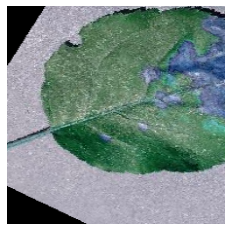

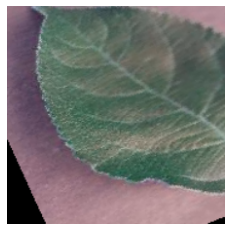

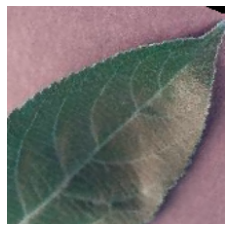

In [9]:
imshow(images[1]);
imshow(images[8]);
imshow(images[12]);

In [10]:
model = models.densenet201(pretrained=True)

In [11]:
for param in model.parameters():
    param.required_grad = False

In [12]:
# change the classifier
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
              ('fc1', nn.Linear(1920, 500)),
              ('relu1', nn.ReLU()),
              ('dropout1', nn.Dropout(p=0.2)),
              ('fc2', nn.Linear(500, 256)),
              ('relu2', nn.ReLU()),
              ('dropout2', nn.Dropout(p=0.2)),
              ('fc3', nn.Linear(256, 5)),
              ('output', nn.LogSoftmax(dim=1))
              
]))
model.classifier = classifier

In [13]:
# Train either on GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:

criterion = nn.NLLLoss()

optimizer = optim.SGD(model.classifier.parameters(), lr = 0.01, momentum=0.9)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
epochs = 1

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        validation_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(val_loader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(val_loader)))

Epoch: 1/1..  Training Loss: 0.717..  Valid Loss: 0.176..  Valid Accuracy: 0.946


In [16]:
#map classes to indexes
model.class_to_idx = map_labels

In [17]:
# save model

s3_client = boto3.client("s3",
                    endpoint_url = "http://192.168.0.29",
                    aws_access_key_id="AKIAPo19vPR_TJaeVgleCiOSUw",
                    aws_secret_access_key="7cSWM1KCXvRpK4ICeDEAfuicEm+QQeuhqOi7cejZ",
                   )
               
buffer = io.BytesIO()
torch.save({"state_dict":model.state_dict(),
           "class_to_idx":model.class_to_idx}, buffer)
s3_client.put_object(Bucket="saved-models", Key='classifier.pth', Body=buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'a0da9534-6a14-424a-b1c0-36e133f7b59e',
  'HostId': '',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'etag': '"e92f8e698c3a7362714c926b6470b53e"',
   'content-length': '0',
   'x-amz-request-id': 'a0da9534-6a14-424a-b1c0-36e133f7b59e',
   'content-type': 'text/plain',
   'server': 'SeagateS3'},
  'RetryAttempts': 0},
 'ETag': '"e92f8e698c3a7362714c926b6470b53e"'}